In [1]:
import cv2
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os
from skimage.io import imread, imsave
from tqdm import tqdm_notebook
import tensorflow as tf


tf.enable_eager_execution()
print('Tensorflow', tf.__version__)

Tensorflow 1.14.0


In [2]:
def imshow(image):
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(image)

def compute_anchor_dimensions(ratios=[0.5, 1, 2],
                              scales=[1, 1.25, 1.58],
                              areas=[32 * 32, 64 * 64, 128 * 128, 256 * 256, 512 * 512]):
    anchor_shapes = {'P{}'.format(i): [] for i in range(3, 8)}
    for area in areas:
        for ratio in ratios:
            a_h = np.sqrt(area / ratio)
            a_w = area / a_h
            for scale in scales:
                h = np.int32(scale * a_h)
                w = np.int32(scale * a_w)
                anchor_shapes['P{}'.format(
                    int(np.log2(np.sqrt(area) // 4)))].append([w, h])
        anchor_shapes['P{}'.format(int(np.log2(np.sqrt(area) // 4)))] = np.array(
            anchor_shapes['P{}'.format(int(np.log2(np.sqrt(area) // 4)))])
    return anchor_shapes

def get_anchors(input_shape=None, tensor=True):
    anchor_dimensions = compute_anchor_dimensions()
    anchors = []
    for i in range(3, 8):
        feature_name = 'P{}'.format(i)
        stride = 2**i
        feature_size = (input_shape) // stride

        dims = anchor_dimensions[feature_name]
        dims = dims[None, None, ...]
        dims = np.tile(dims, reps=[feature_size, feature_size, 1, 1])

        rx = (np.arange(feature_size) + 0.5) * (stride)
        ry = (np.arange(feature_size) + 0.5) * (stride)
        sx, sy = np.meshgrid(rx, ry)
        cxy = np.stack([sx, sy], axis=-1)
        cxy = cxy[:, :, None, :]
        cxy = np.tile(cxy, reps=[1, 1, 9, 1])
        anchors.append(np.reshape(
            np.concatenate([cxy, dims], axis=-1), [-1, 4]))
    anchors = np.concatenate(anchors, axis=0)
    if tensor:
        anchors = tf.constant(anchors, dtype=tf.float32)
    return anchors

def change_box_format(boxes, return_format='xywh'):
    boxes = tf.cast(boxes, dtype=tf.float32)
    if return_format == 'xywh':

        return tf.stack([(boxes[..., 2] + boxes[..., 0]) / 2.0,
                         (boxes[..., 3] + boxes[..., 1]) / 2.0,
                         boxes[..., 2] - boxes[..., 0],
                         boxes[..., 3] - boxes[..., 1]], axis=-1)
    elif return_format == 'x1y1x2y2':

        return tf.stack([boxes[..., 0] - boxes[..., 2] / 2.0,
                         boxes[..., 1] - boxes[..., 3] / 2.0,
                         boxes[..., 0] + boxes[..., 2] / 2.0,
                         boxes[..., 1] + boxes[..., 3] / 2.0], axis=-1)
    return 'You should not be here'

def draw_bboxes(image, bbox_list):
    image = image / 255.
    h, w = image.shape.as_list()[:2]
    bboxes = tf.cast(tf.stack([
        bbox_list[:, 1] / h, bbox_list[:, 0] /
        w, bbox_list[:, 3] / h, bbox_list[:, 2] / w
    ], axis=-1), dtype=tf.float32)

    colors = tf.random.uniform(maxval=1, shape=[bbox_list.shape[0], 3])
    return tf.image.convert_image_dtype(tf.image.draw_bounding_boxes(image[None, ...],
                                                                     bboxes[None, ...],
                                                                     colors)[0, ...], dtype=tf.uint8)

def draw_boxes_cv2(image, bbox_list, class_ids, scores, model_input_shape, classes):
    img = np.uint8(image).copy()
    bbox_list = np.array(bbox_list, dtype=np.int32)
    h, w = img.shape[:2]
    h_scale, w_scale = h / model_input_shape, w / model_input_shape
    bbox_list = np.int32(bbox_list * np.array([w_scale, h_scale] * 2))
    for box, cls_, score in zip(bbox_list, class_ids, scores):
        text = classes[cls_] + '' + str(np.round(score, 2))
        text_orig = (box[0]+2, box[1]+12)
        text_bg_xy1 = (box[0], box[1])
        text_bg_xy2 = (box[0]+60, box[1]+18)
        img = cv2.rectangle(img, text_bg_xy1,
                            text_bg_xy2, [255, 252, 193], -1)
        img = cv2.putText(img, text, text_orig, cv2.FONT_HERSHEY_COMPLEX_SMALL, .6, [0, 0, 0], 2, lineType=cv2.LINE_AA)
        img = cv2.putText(img, text, text_orig, cv2.FONT_HERSHEY_COMPLEX_SMALL, .6, [255, 255, 255], 1, lineType=cv2.LINE_AA)
        img = cv2.rectangle(img, (box[0], box[1]),
                            (box[2], box[3]), [30, 15, 200], 1)
    return img

def decode_targets(classification_outputs,
                   regression_outputs,
                   input_shape=512,
                   classification_threshold=0.05,
                   nms_threshold=0.5):
    scale_factors = tf.constant([10.0, 10.0, 5.0, 5.0])
    anchors = get_anchors(input_shape=input_shape, tensor=True)

    class_ids = tf.argmax(classification_outputs, axis=-1)

    confidence_scores = tf.reduce_max(
        tf.nn.sigmoid(classification_outputs), axis=-1)
    regression_outputs = regression_outputs / scale_factors
    boxes = tf.concat([(regression_outputs[:, :2] * anchors[:, 2:] + anchors[:, :2]),
                       tf.math.exp(
                           regression_outputs[:, 2:]) * anchors[:, 2:]
                       ], axis=-1)
    boxes = change_box_format(boxes, return_format='x1y1x2y2')

    nms_indices = tf.image.non_max_suppression(boxes,
                                               confidence_scores,
                                               score_threshold=classification_threshold,
                                               iou_threshold=nms_threshold,
                                               max_output_size=100)
    final_class_ids = tf.gather(class_ids, nms_indices)
    final_scores = tf.gather(confidence_scores, nms_indices)
    final_boxes = tf.cast(tf.gather(boxes, nms_indices), dtype=tf.int32)

    matched_anchors = tf.gather(anchors, tf.where(
        confidence_scores > classification_threshold)[:, 0])
    matched_anchors = tf.cast(change_box_format(matched_anchors, return_format='x1y1x2y2'),
                              dtype=tf.int32)
    return final_boxes, final_class_ids, final_scores, matched_anchors

def conv_block(x,
               n_filters,
               size,
               strides=1,
               kernel_init='he_normal',
               bias_init='zeros',
               bn_activated=False, name=''):
    x = tf.keras.layers.Conv2D(filters=n_filters,
                               kernel_size=size,
                               padding='same',
                               strides=strides,
                               kernel_initializer=kernel_init,
                               bias_initializer=bias_init,
                               name='conv_' + name if name else None)(x)
    if bn_activated:
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)
    return x

def Upsampling(tensor, scale=2):
    dims = tensor.shape.as_list()[1:-1]
    return tf.image.resize_bilinear(tensor, size=[dims[0] * scale, dims[1] * scale], align_corners=True)

def build_classification_subnet(n_classes=None, n_anchors=9, p=0.01):
    input_layer = tf.keras.layers.Input(shape=[None, None, 256])
    x = input_layer
    for i in range(4):
        x = conv_block(
            x, 256, 3, kernel_init=tf.keras.initializers.RandomNormal(0.0, 0.01))
        x = tf.keras.layers.ReLU()(x)
    bias_init = -np.log((1 - p) / p)
    output_layer = tf.keras.layers.Conv2D(filters=n_classes * n_anchors,
                                          kernel_size=3,
                                          padding='same',
                                          kernel_initializer=tf.keras.initializers.RandomNormal(
                                              0.0, 0.01),
                                          bias_initializer=tf.keras.initializers.Constant(
                                              value=bias_init),
                                          activation=None)(x)
    output_layer = tf.keras.layers.Reshape(
        target_shape=[-1, n_classes])(output_layer)
    return tf.keras.Model(inputs=input_layer, outputs=output_layer, name='classification_subnet')

def build_regression_subnet(n_anchors=9):
    input_layer = tf.keras.layers.Input(shape=[None, None, 256])
    x = input_layer
    for i in range(4):
        x = conv_block(
            x, 256, 3, kernel_init=tf.keras.initializers.RandomNormal(0.0, 0.01))
        x = tf.keras.layers.ReLU()(x)
    output_layer = tf.keras.layers.Conv2D(filters=4 * n_anchors,
                                          kernel_size=3,
                                          padding='same',
                                          kernel_initializer=tf.keras.initializers.RandomNormal(
                                              0.0, 0.01),
                                          bias_initializer=tf.keras.initializers.zeros(),
                                          activation=None)(x)
    output_layer = tf.keras.layers.Reshape(
        target_shape=[-1, 4])(output_layer)
    return tf.keras.Model(inputs=input_layer, outputs=output_layer, name='regression_subnet')

In [3]:
class_map = {value: idx for idx, value in enumerate(['bus',
                                                     'traffic light',
                                                     'traffic sign',
                                                     'person',
                                                     'bike',
                                                     'truck',
                                                     'motor',
                                                     'car',
                                                     'train',
                                                     'rider'])}

INPUT_SHAPE = 640
BATCH_SIZE = 1
N_CLASSES = len(class_map)

In [5]:
class LossV2():
    def __init__(self, n_classes=None):
        self.num_classes = n_classes
        self.smooth_l1 = tf.compat.v2.losses.Huber(delta=0.11, reduction='none')

    def focal_loss(self, y_true, y_pred, alpha=0.25, gamma=2):
        y_true = tf.one_hot(
            tf.cast(y_true, dtype=tf.int32), depth=self.num_classes + 1)
        y_true = y_true[:, :, 1:]
        y_pred_ = tf.sigmoid(y_pred)

        at = alpha * y_true + (1 - y_true) * (1 - alpha)
        pt = y_true * y_pred_ + (1 - y_true) * (1 - y_pred_)
        f_loss = at * tf.pow(1 - pt, gamma) * tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred)

        return f_loss

    def smooth_l1_(self, y_true, y_pred, sigma=3.0):
        y_true = tf.cast(y_true, dtype=y_pred.dtype)
        sigma = tf.cast(sigma, dtype=y_pred.dtype)
        x = y_true - y_pred
        abs_x = tf.abs(x)
        sigma_squared = tf.square(sigma)
        quadratic = 0.5 * tf.square(sigma * x)
        linear = abs_x - (0.5 / sigma_squared)
        smooth_l1_loss = tf.where(
            tf.less_equal(abs_x, 1. / sigma_squared), quadratic, linear)
        return smooth_l1_loss

    def __call__(self, tensor):
        classification_targets = tensor[0]
        classification_predictions = tensor[1]
        regression_targets = tensor[2]
        regression_predictions = tensor[3]
        background_mask = tensor[4]
        ignore_mask = tensor[5]

        background_mask = tf.cast(
            background_mask, dtype=tf.bool, name='bg_cast')
        ignore_mask = tf.cast(ignore_mask, dtype=tf.bool, name='ig_cast')

        num_positive_detections = tf.maximum(tf.reduce_sum(
            tf.cast(background_mask, dtype=tf.float32), axis=-1), 1.0)

        positive_classification_mask = tf.expand_dims(
            tf.logical_not(ignore_mask), axis=-1)
        positive_classification_mask = tf.tile(
            positive_classification_mask, multiples=[1, 1, self.num_classes])

        positive_regression_mask = tf.expand_dims(background_mask, axis=-1)
        positive_regression_mask = tf.tile(
            positive_regression_mask, multiples=[1, 1, 4])

        Lcls = self.focal_loss(classification_targets,
                               classification_predictions)
        Lreg = self.smooth_l1(regression_targets, regression_predictions)
        Lcls = Lcls * \
            tf.cast(positive_classification_mask, dtype=tf.float32)
        Lreg = Lreg * tf.cast(positive_regression_mask, dtype=tf.float32)

        Lcls = tf.reduce_sum(
            Lcls, axis=[1, 2]) / num_positive_detections
        Lreg = tf.reduce_sum(
            Lreg, axis=[1, 2]) / num_positive_detections

        Lcls = tf.reduce_mean(Lcls)
        Lreg = tf.reduce_mean(Lreg)
        return Lreg, Lcls, tf.reduce_mean(num_positive_detections)
        
def RetinaNet(input_shape=None, n_classes=None, training=False):
    H = W = input_shape
    num_anchors = get_anchors(input_shape=H).shape[0]
    loss_fn = LossV2(n_classes=n_classes)

    base_model = tf.keras.applications.ResNet50(
        input_shape=[H, W, 3], weights='imagenet', include_top=False)

    resnet_block_output_names = [
        'activation_21', 'activation_39', 'activation_48']

    resnet_block_outputs = {'C{}'.format(idx + 3): base_model.get_layer(
        layer).output for idx, layer in enumerate(resnet_block_output_names)}
    resnet_block_outputs = {level: conv_block(
        tensor, 256, 1, name=level + '_1x1') for level, tensor in resnet_block_outputs.items()}

    P5 = resnet_block_outputs['C5']
    P6 = conv_block(base_model.get_layer(
        'activation_48').output, 256, 3, strides=2, name='P6')
    P6_relu = tf.keras.layers.ReLU(name='P6')(P6)
    P7 = conv_block(P6_relu, 256, 3, strides=2, name='P7')
    M4 = tf.keras.layers.add([tf.keras.layers.Lambda(Upsampling, arguments={'scale': 2}, name='P5_UP')(
        P5), resnet_block_outputs['C4']], name='P4_merge')
    M3 = tf.keras.layers.add([tf.keras.layers.Lambda(Upsampling, arguments={'scale': 2}, name='P4_UP')(
        M4), resnet_block_outputs['C3']], name='P3_merge')
    P4 = conv_block(M4, 256, 3, name='P4')
    P3 = conv_block(M3, 256, 3, name='P3')
#         pyrammid_features = [P7, P6, P5, P4, P3]
    pyrammid_features = [P3, P4, P5, P6, P7]


    classification_subnet = build_classification_subnet(
        n_classes=n_classes)
    regression_subnet = build_regression_subnet()

    classification_outputs = [classification_subnet(
        level) for level in pyrammid_features]
    regression_outputs = [regression_subnet(
        level) for level in pyrammid_features]

    classification_head = tf.keras.layers.concatenate(
        classification_outputs, axis=1, name='classification_head')
    regression_head = tf.keras.layers.concatenate(
        regression_outputs, axis=1, name='regression_head')

    image_input = base_model.input
    classification_targets = tf.keras.layers.Input(shape=[num_anchors])
    regression_targets = tf.keras.layers.Input(shape=[num_anchors, 4])
    background_mask = tf.keras.layers.Input(shape=[num_anchors])
    ignore_mask = tf.keras.layers.Input(shape=[num_anchors])

    Lreg, Lcls, _ = tf.keras.layers.Lambda(loss_fn)([classification_targets,
                                                     classification_head,
                                                     regression_targets,
                                                     regression_head,
                                                     background_mask,
                                                     ignore_mask])

    Lreg = tf.keras.layers.Lambda(
        lambda x: tf.reshape(x, [-1, 1]), name='box')(Lreg)
    Lcls = tf.keras.layers.Lambda(
        lambda x: tf.reshape(x, [-1, 1]), name='focal')(Lcls)

    if training:
        _inputs = [image_input, classification_targets,
                   regression_targets, background_mask, ignore_mask]
        _outputs = [Lreg, Lcls]
    else:
        _inputs = [image_input]
        _outputs = [classification_head, regression_head]
    model =  tf.keras.Model(inputs=_inputs, outputs=_outputs, name='RetinaNet')
    return model


model = RetinaNet(input_shape=INPUT_SHAPE,
                  n_classes=N_CLASSES, training=False)
model.load_weights('model_files/weights')

/Users/srihari/tf2.0/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
W0906 13:58:27.404274 4449015232 deprecation.py:323] From /Users/srihari/tf2.0/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [6]:
def visualize_outputs(image_path):
    classes =[
            'bus',
            'traffic light',
            'traffic sign',
            'person',
            'bike',
            'truck',
            'motor',
            'car',
            'train',
            'rider'
    ]
    image = imread(image_path)
    image_viz = image.copy()
    image = cv2.resize(image, (INPUT_SHAPE, INPUT_SHAPE))
    image = image[:, :, ::-1] - np.array([103.939, 116.779, 123.68])
    cls_preds, reg_preds = model.predict(image[None, ...])
    decoded_boxes, decoded_class_ids, decoded_scores, matched_anchors = \
        decode_targets(cls_preds[0],
                       reg_preds[0],
                       input_shape=INPUT_SHAPE,
                       classification_threshold=0.25,
                       nms_threshold=.50)
    image_viz = draw_boxes_cv2(image_viz,
                               decoded_boxes,
                               decoded_class_ids,
                               decoded_scores,
                               INPUT_SHAPE, 
                               classes)
    return image_viz

In [7]:
val_images = glob('../../../../bdd/bdd100k/images/100k/val/*')
print('Found {} images'.format(len(val_images)))

Found 10000 images


In [8]:
!rm test_outputs/*

rm: test_outputs/*: No such file or directory


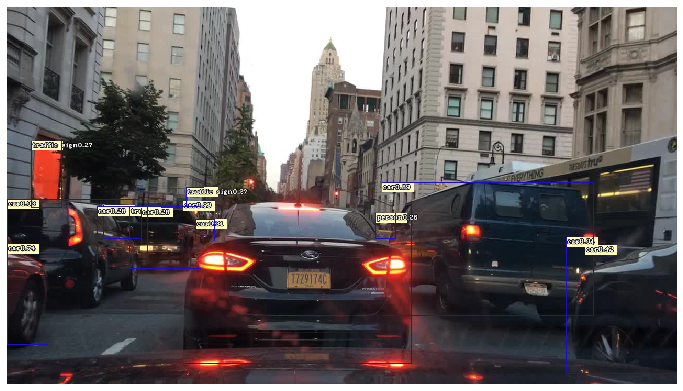

In [9]:
for i in tqdm_notebook(range(100)):
    result = visualize_outputs(val_images[i])
#     imsave('test_outputs/' + val_images[i].split('/')[-1], result)
    imshow(result)
    break